In [2]:
import os
import re
import json
from sklearn.cluster import KMeans
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering

In [3]:
GMM_CONST = "GMM"
KMEANS_CONST = "KMeans"
SPECTRAL_CONST = "SpectralClustering"
AGGLOMERATIVE_CONST = "AgglomerativeClustering"
HDBSCAN_CONST = "HDBSCAN"

In [4]:
methods = {
    GMM_CONST: lambda n: GaussianMixture(n_components=n, random_state=42, covariance_type='diag', reg_covar=1e-3),
    KMEANS_CONST: lambda n: KMeans(n_clusters=n, random_state=42),
    SPECTRAL_CONST: lambda n: SpectralClustering(n_clusters=n, affinity='nearest_neighbors', random_state=42),
    AGGLOMERATIVE_CONST: lambda n: AgglomerativeClustering(n_clusters=n),
}

In [5]:
def list_files(directory, extension:str=".npz"):
    """Liste tous les fichiers .npz dans le dossier spécifié."""
    return [f for f in os.listdir(directory) if f.endswith(extension)]

In [6]:
def get_filename_without_extension(path: str) -> str:
    return os.path.splitext(os.path.basename(path))[0]

In [7]:
def extract_code(filename: str) -> str:
    match = re.search(r"(n\d+)", filename)
    return match.group(1) if match else ""

In [8]:
def extract_code_2(filename: str) -> str:
    match = re.search(r"(n\d+_\d+)", filename)
    return match.group(1) if match else ""

In [9]:
def load_and_process_flat(file_name : str,
                          base_path,
                          layer_name : str = "layer_40"):
    data = np.load(f"{base_path}/heatmap/{file_name}")
    heatmaps = data[layer_name]
    heatmaps = np.abs(heatmaps)
    heatmaps_flat = heatmaps.reshape(heatmaps.shape[0], -1)
    return heatmaps, heatmaps_flat

In [10]:
def visualize_clusters(data, min_cluster, max_cluster, methods, picture_name, base_path):
    num_methods = len(methods)

    for cluster_idx, cluster_num in enumerate(range(min_cluster, max_cluster + 1)):
        fig, axes = plt.subplots(nrows=num_methods, ncols=max(4, cluster_idx + min_cluster), figsize=(16, 4 * num_methods))
        heatmaps_by_method = {}
        vmin, vmax = float("inf"), float("-inf")

        for method in methods:
            cluster_label = data[f"{cluster_num}_{method}"]
            heatmaps, _ = load_and_process_flat(picture_name, base_path, layer_name="layer_40")
            heatmaps_by_cluster = {}

            for cluster in set(cluster_label):
                if cluster == -1:
                    continue
                indices = np.where(cluster_label == cluster)[0]
                cluster_heatmaps = heatmaps[indices]
                heatmaps_by_cluster[cluster] = cluster_heatmaps

                if cluster_heatmaps.shape[0] > 0:
                    combined_heatmap = np.sum(cluster_heatmaps, axis=0)
                    vmin = min(vmin, combined_heatmap.min())
                    vmax = max(vmax, combined_heatmap.max())

            heatmaps_by_method[method] = heatmaps_by_cluster

        for method_idx, method in enumerate(methods):
            heatmaps_by_cluster = heatmaps_by_method[method]

            for cluster, heatmaps in heatmaps_by_cluster.items():
                if heatmaps.shape[0] == 0:
                    continue
                combined_heatmap = np.sum(heatmaps, axis=0)

                ax = axes[method_idx, cluster] if num_methods > 1 else axes[cluster]
                im = ax.imshow(combined_heatmap, cmap="jet", alpha=0.7, vmin=vmin, vmax=vmax)
                ax.axis("off")
                ax.set_title(f"Cluster {cluster}\n{method}\n{heatmaps.shape[0]} éléments")

            # Ajouter la barre des couleurs dans la dernière colonne
            cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position relative de la colorbar
            fig.colorbar(im, cax=cax)

        #plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ajustement pour laisser de la place à la colorbar
        plt.show()

TODO : put file name in key and in values a tuple with min and max born and cluster method to display

In [16]:
dictionary_file_to_which_cluster_visualization = {
    "clusters_n01829413_46.npz": (2, 2, [KMEANS_CONST]),
    "clusters_n01829413_5429.npz": (2, 2, [KMEANS_CONST]),
}

TODO : update the base_path

In [17]:
base_path = "./data/v6/clusters"

In [18]:
directory_clusters = f"{base_path}/clusters"
files_clusters = list_files(directory_clusters, extension=".npz")

In [19]:
with open(f"{base_path}/imagenet_class_index_reversed.json", "r") as file:
    dictionary_class_index = json.load(file)

Visualizing clusters for hornbill (n01829413)


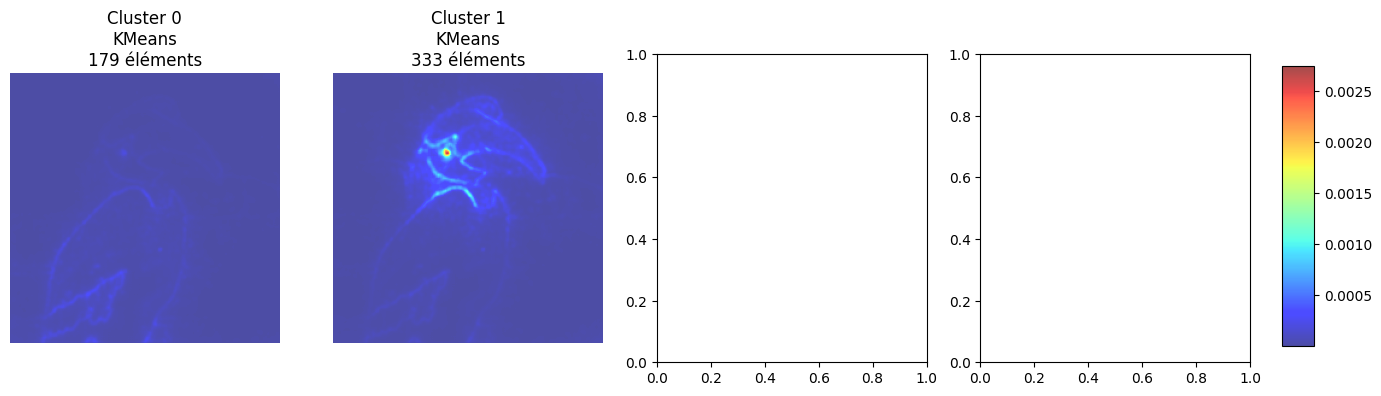

Visualizing clusters for hornbill (n01829413)


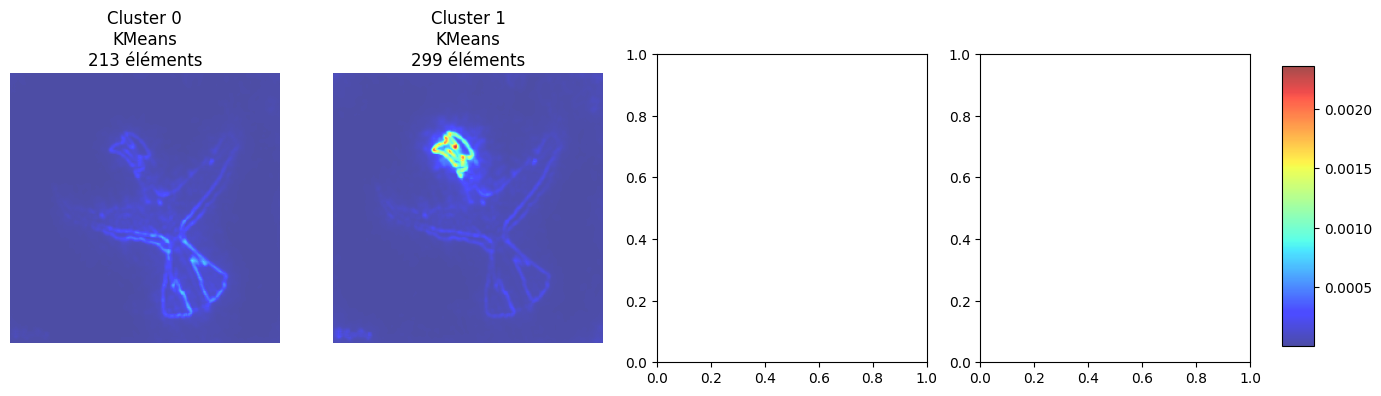

In [20]:
for key in dictionary_file_to_which_cluster_visualization:
    file_path = f"{directory_clusters}/{key}"
    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist.")
        continue
    min_cluster, max_cluster, methods = dictionary_file_to_which_cluster_visualization[key]
    data = np.load(file_path)
    picture_name = get_filename_without_extension(file_path)
    class_id = extract_code(picture_name)
    heatmap_file_name = f"{extract_code_2(picture_name)}.npz"
    print(f"Visualizing clusters for {dictionary_class_index[class_id]} ({class_id})")
    visualize_clusters(data, min_cluster, max_cluster, methods, heatmap_file_name, base_path)